## Goals
- Tune the model parameters to get better results
- Save the tuned model

## Imports

In [1]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import pickle
import os

# Notebook Utilities
%matplotlib inline

In [2]:
## Pipelines
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Transformers
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer

## Scalers
from sklearn.preprocessing import StandardScaler

## Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Parameter Tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

## Functions

In [3]:
# Function which seperates feature types
def data_seperator(data, depend=None):
    # Stores dependant variable
    if depend != None:
        data_depend = data[depend]
        data = data.drop(depend, axis=1)
    else:
        data_depend = []
    
    # Stores categorical features
    select = [data.columns[i] for i in np.where(data.dtypes == 'O')[0]]
    data_categ = pd.DataFrame(data[select])
    
    # Stores all numerical features
    data_num = data.drop(select, axis=1)
    
    # Seperating time features from numerical features
    select = [i for i in data_num.columns if 'year' in i.lower() or 'yr' in i.lower() or 'day' in i or 'week' in i.lower()]
    data_time = pd.DataFrame(data_num[select])
    data_num = data_num.drop(select, axis=1)
    
    # Seperating discrete and continuous features
    select = [feature for feature in data_num if len(data_num[feature].unique()) < 10]
    data_discrete = pd.DataFrame(data_num[select])
    data_continuous = data_num.drop(select, axis=1)
    
    # Returning the features
    return data_num, data_discrete, data_continuous, data_categ, data_time, data_depend

In [4]:
def impute_first_letter(df):
    for i in range(len(df)):
        for x in range(len(df[i])):
            df[i][x] = df[i][x][0]
    return df

## Dataset Information
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

- Source: https://www.kaggle.com/competitions/titanic/data
- Use Machine Learning to create a model that predicts which passengers survived the Titanic shipwreck.
- I chose this dataset because it has many types of features. 
- It has features with missing values and outliers
- Overall, I think this is a good dataset for practicing the basics.

## Working Directory

In [5]:
old_path = os.getcwd()
os.chdir('..')
path = os.getcwd()

## Reading Data

In [6]:
x_train = pd.read_csv('data/processed/x_train.csv')
x_test = pd.read_csv('data/processed/x_test.csv')
y_train = pd.read_csv('data/processed/y_train.csv')
y_test = pd.read_csv('data/processed/y_test.csv')

In [7]:
y_test.head()

,Survived
0,0
1,1
2,0
3,0
4,1


## Loading the Model

In [8]:
with open('model/model.pkl', 'rb') as f:
    pipe = pickle.load(f)

In [9]:
pipe.fit(x_train, np.ravel(y_train))

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Continuous',
                                                  Pipeline(steps=[('Imputer',
                                                                   KNNImputer()),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>))]),
                                                  Index(['Age', 'Fare'], dtype='object')),
                                                 ('Discrete',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Pclass', 'SibSp', 'P...
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function impute_first_letter at 0x0000023C4C300A60>)),
                                                                  ('Encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=10))]),
                                                  array(['Cabin'], dtype='<U5'))])),
                ('classifier', RandomForestClassifier())])

## Evaluating the Model

In [10]:
y_pred = pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       266
           1       0.76      0.74      0.75       152

    accuracy                           0.82       418
   macro avg       0.81      0.80      0.81       418
weighted avg       0.82      0.82      0.82       418



## Tuning the Model

In [11]:
# Parameters for tuning
parameters = {
    'classifier__n_estimators': [100, 200, 300, 400],
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_features': ["sqrt", "log2"],
}

In [12]:
grid_search = GridSearchCV(pipe, param_grid=parameters, cv=5, scoring='accuracy')

In [13]:
grid_search.fit(x_train, np.ravel(y_train))

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('Continuous',
                                                                         Pipeline(steps=[('Imputer',
                                                                                          KNNImputer()),
                                                                                         ('Scaler',
                                                                                          FunctionTransformer(feature_names_out='one-to-one',
                                                                                                              func=<ufunc 'log1p'>))]),
                                                                         Index(['Age', 'Fare'], dtype='object')),
                                                                        ('Discrete',
                                                                         Pipeline(steps=[('Imputer',
                                                                                          SimpleImputer(strategy='most_frequent'))]...
                                                                                                              func=<function impute_first_letter at 0x0000023C4C300A60>)),
                                                                                         ('Encoder',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=10))]),
                                                                         array(['Cabin'], dtype='<U5'))])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_features': ['sqrt', 'log2'],
                         'classifier__n_estimators': [100, 200, 300, 400]},
             scoring='accuracy')

In [14]:
grid_search.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_features': 'log2',
 'classifier__n_estimators': 100}

## Tuned Model

In [15]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Continuous',
                                                  Pipeline(steps=[('Imputer',
                                                                   KNNImputer()),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log1p'>))]),
                                                  Index(['Age', 'Fare'], dtype='object')),
                                                 ('Discrete',
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  Index(['Pclass', 'SibSp', 'P...
                                                  Pipeline(steps=[('Imputer',
                                                                   SimpleImputer(fill_value='N',
                                                                                 strategy='constant')),
                                                                  ('Scaler',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<function impute_first_letter at 0x0000023C4C300A60>)),
                                                                  ('Encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=10))]),
                                                  array(['Cabin'], dtype='<U5'))])),
                ('classifier', RandomForestClassifier(max_features='log2'))])

## Evalualting the Tuned Model

In [16]:
y_pred = grid_search.predict(x_test)

In [17]:
accuracy_score(y_test, y_pred)

0.8301435406698564

In [18]:
f1_score(y_test, y_pred)

0.759322033898305

Text(0.5, -7.277777777777782, 'Predicted Values')

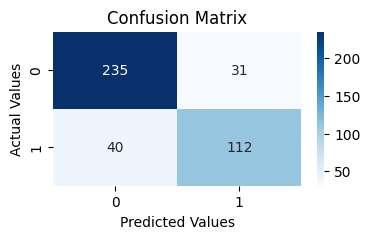

In [19]:
cm = confusion_matrix(y_test,y_pred)
plt.figure(figsize=(4,2))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")

In [20]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87       266
           1       0.78      0.74      0.76       152

    accuracy                           0.83       418
   macro avg       0.82      0.81      0.81       418
weighted avg       0.83      0.83      0.83       418



## Saving the Tuned Model

In [21]:
with open('model/model_tuned.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

## Saving the predicted values

In [22]:
results = pd.concat([pd.read_csv('data/external/new_y_test.csv').drop('Survived', axis=1), 
                     pd.DataFrame(y_pred, columns=['Survived'])], axis=1)
results.to_csv('data/predicted/predicted.csv', index=False)
results.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [23]:
os.chdir(old_path)

## Conclusions
- Tried various parameters on the model using CV methods
- Selected the parameters to use in the model